#介紹
這篇主要是用來介紹如何使用hls4ml，透過此方式可以快速部屬訓練模型到FPGA上。
#大綱
這次的實做會主要分為四個部份


*   量化模型部屬（brevita,Qkeras)
*   AutoQkeras(外部來源）
*   剪枝策略
*   Hls4ml參數調整

我們接著往下繼續介紹。


## 量化模型部屬
在為了縮小模型部屬的硬體使用量，我們可以透過量化的方式減少模型在推理時所使用的精度大小(INT8)，此種方式可以減少在電路部屬中的硬體使用率。傳統模型大部分的參數都會使用在float或者是double，但是在實際電路中要製作浮點數加法器以及乘法器通常都會需要大量的硬體資源，因此在實際部屬中，量化算是一個不可或缺的部份。

而在模型量化方式又有兩種選擇PTQ以及QAT。而本次就並不會過多介紹兩者的差異性，要了解的主要是在QAT中，可以有效的減少計算精度下降的準確度損失。

在hls4ml當中支援三種量化的框架，Qkeras,Brevitas以及QONNX。Qkeras在目前來講是hls4ml中支援最好的一個框架，而在Brevitas hls4ml並沒有支持原生轉換，模型訓練之後，並須將其轉為QONNX格式。因此本次實做中主要會使用Qkeras。

當進行本次實驗時，請務必確認作業環境為 Linux 系統，這是因為 hls4ml 會直接調用 Xilinx 的 Vitis 與 Vivado 工具，而這些工具僅支援在 Linux 環境下執行。

此外，由於最新版的 TensorFlow 不再支援 QKeras，因此本實驗將使用 TensorFlow 2.12.2。需要注意的是，TensorFlow 2.12.2 不支援 CUDA 12 以上版本，因此必須確認系統中安裝的是 CUDA 12 以下的版本，否則將無法使用 GPU 加速。

如果你覺得這些環境設定過於繁瑣或麻煩，建議使用 Docker。TensorFlow 官方已提供包含 2.12.2 版本及相容 CUDA 驅動的 Docker 映像檔

[這邊](https://hub.docker.com/layers/tensorflow/tensorflow/2.12.0-gpu/images/sha256-ce32fe3c53f94938de1513b3fe5fa25aa655a2f4c4bced42cf598fb8ce911219)

# Cifar10 Dataset
本次實驗使用cifar10 Dataset，並且有使用資料增強

In [ ]:
import qkeras.utils
import tensorflow_model_optimization as tfmot
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import clone_model
from tensorflow.keras import optimizers
import qkeras
from qkeras.utils import load_qmodel
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

import json
import pprint
import numpy as np
import six
import tempfile


from qkeras.autoqkeras import *
from qkeras import *
from qkeras.utils import model_quantize
from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings


print("using tensorflow", tf.__version__)
import numpy as np
import urllib.request
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow_addons as tfa
import tensorflow as tf


(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# X_train = tf.image.resize(X_train, (16,16))
# X_test = tf.image.resize(X_test, (16,16))
mean = np.mean(X_train, axis=(0, 1, 2, 3))
std = np.std(X_train, axis=(0, 1, 2, 3))

X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)

y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')



using tensorflow 2.12.0


#Qkeras模型
# 📘 QKeras 中的量化精度表示方式

在 QKeras 中，我們可以使用多種方式來定義模型中各層的量化精度（Quantization Precision）。
而我們這裡介紹兩中比較常用的

---

##  `quantized_bits(bits, integer, keep_negative=True, alpha=None, symmetric=True)`

**定點量化格式**，用來表示權重、偏差、激活輸出等。

**參數說明：**
- `bits`：總位元數（表示總精度）
- `integer`：整數位元數（小數點左側）
- `keep_negative`：是否保留負號（預設為 True，對稱量化）
- `alpha`：縮放因子，常用於某些激活函數
- `symmetric`：是否使用對稱範圍（例如 [-1, 1)）

---

##  `quantized_po2((bits=8, max_value=-1))`

**定點量化格式**，跟上述方法相同，都可以用來表示權重以及輸出，但是是透過PO2(Power-of-2)去實現，這種方法可以稍微的減少乘法器的使用。

**參數說明：**
- `bits`：總位元數
- `symmetric`：所代表的最大值


# AutoQkeras
而除了手動建立量化之外，也可以透過Qkeras提供的AutoQkeras自動化量化，[連結這邊](https://github.com/google/qkeras/blob/master/notebook/AutoQKeras.ipynb)。透過演算法找出最小資源的量化設定，但是在設定上會比較複雜跟耗時，因為推算出設定需要一些時間，因此根據自己需求使用。

而下面我們簡易製作一個輸入為(32,32,3)的CNN模型。而在hls4ml原生可以支援一些keras的function
在這篇[文章](https://www.politesi.polimi.it/retrieve/5f30073b-bd93-4e11-9d1e-7e9a54b6583a/2023_07_Carini.pdf#:~:text=5,DSPs%20LUTs%20BRAMs%20FFs)中可以找到。由於眾多就不一一列出了，主要注意的是無法使用GlobalAveragePooling，會提醒的原因是在許多的CNN輕量化模型中都會使用到例如ResNet。


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Flatten, GlobalAveragePooling2D,Activation,MaxPooling2D,GlobalAveragePooling1D,Reshape,Add
from qkeras import QConv2D, QActivation, QDense, quantized_bits, QDepthwiseConv2D,QSeparableConv2D,QLSTM
from qkeras import QDepthwiseConv2DBatchnorm, QActivation, quantized_bits,quantized_relu,QConv2DBatchnorm,QBatchNormalization,QMobileNetSeparableConv2D
from qkeras import quantized_po2
# keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from sklearn.model_selection import train_test_split

# qkeras imports
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.autoqkeras.utils import print_qmodel_summary

quantizer = "quantized_bits(8,0,alpha=1)"
quantizer = "quantized_bits(6,0,alpha=1)"

def build_qkeras_model(input_shape=(32, 32, 3), num_classes=10):
    inp = Input(shape=input_shape)

    x = QConv2D(16, 3, strides=1,
                kernel_quantizer=quantizer,padding='same',
                bias_quantizer=quantizer,activation='quantized_relu(6)')(inp)
    x = MaxPooling2D((2,2))(x)
    # x = QBatchNormalization(activation='quantized_relu(6)')(x)
    x = QConv2D(16, 3, strides=1,
                kernel_quantizer=quantizer,padding='same',
                bias_quantizer=quantizer,activation='quantized_relu(6)')(x)
    x = MaxPooling2D((2,2))(x)
    # x = QBatchNormalization(activation='quantized_relu(6)')(x)
    x = QConv2D(32, 3, strides=1,
                kernel_quantizer=quantizer,padding='same',
                bias_quantizer=quantizer,activation='quantized_relu(6)')(x)
    x = MaxPooling2D((2,2))(x)
    # x = QBatchNormalization(activation='quantized_relu(6)')(x)
    # x = QBatchNormalization(activation='quantized_relu(6)')(x)
    x = QConv2D(64, 3, strides=1,
                kernel_quantizer=quantizer,padding='same',
                bias_quantizer=quantizer,activation='quantized_relu(6)')(x)
    # x = QBatchNormalization(activation='quantized_relu(6)')(x)
    # x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = QDense(128, name='fc1', kernel_quantizer=quantizer,kernel_initializer='lecun_uniform',activation='quantized_relu(6)')(x)
    # x = Dropout(0.2)(x)
    # x = QDense(64, name='fc2', kernel_quantizer=quantizer,kernel_initializer='lecun_uniform')(x)

    x = QDense(num_classes, name='output_dense', kernel_quantizer=quantizer,kernel_initializer='lecun_uniform')(x)
    # x = Activation("softmax", name="softmax")(x)
    return Model(inputs=inp, outputs=x)


#Training
在Qkeras並不需要透過其他設定就可以直接執行訓練，與原版並沒有任何差異。重點在訓練過程中必須要檢查與原本模型的準確度差異為多少，例如本此使用的模型在不量化的情況下可以到接近80\%，因此下降大約5\%算是可以接受了。但是如果差異過大，可能就必須要在重新考慮量化的參數是否需要在進行調整，要稍微找到平衡點。

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from resnet import q_resnet18
from effectnet import qefficientnet_cifar10
from keras.optimizers.schedules.learning_rate_schedule import CosineDecayRestarts
model = build_qkeras_model(input_shape=(32, 32, 3), num_classes=10)
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=0.001,
    first_decay_steps=10,
    t_mul=2.0,              # 週期倍增倍數（例如每次加倍）
    m_mul=1.0,              # 每次 restart 時學習率倍率
    alpha=0.0               # 最小學習率相對於 initial 的比例
)
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

checkpoint_cb = ModelCheckpoint(
    filepath='model_cpu.h5',         # 儲存的檔名
    monitor='val_accuracy',           # 你想監控的指標
    save_best_only=True,              # 只儲存最好的（非每個 epoch 都存）
    mode='max',                       # val_accuracy 越高越好
    verbose=1                         # 顯示儲存訊息
)
tf.keras.backend.clear_session()

model.summary()
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
history = model.fit(datagen.flow(X_train, y_train,
                                     batch_size=64), epochs=500, batch_size=64, validation_data=(X_test,y_test),callbacks = checkpoint_cb)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 q_conv2d (QConv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 q_conv2d_1 (QConv2D)        (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 q_conv2d_2 (QConv2D)        (None, 8, 8, 32)          4640  

2025-07-27 00:33:21.994058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


781/782 [============================>.] - ETA: 0s - loss: 1.6425 - accuracy: 0.4023
Epoch 1: val_accuracy improved from -inf to 0.50510, saving model to model_cpu.h5
782/782 [==============================] - 14s 17ms/step - loss: 1.6420 - accuracy: 0.4025 - val_loss: 1.3607 - val_accuracy: 0.5051
Epoch 2/500
779/782 [============================>.] - ETA: 0s - loss: 1.3417 - accuracy: 0.5146
Epoch 2: val_accuracy improved from 0.50510 to 0.55960, saving model to model_cpu.h5
782/782 [==============================] - 13s 17ms/step - loss: 1.3412 - accuracy: 0.5148 - val_loss: 1.2197 - val_accuracy: 0.5596
Epoch 3/500
782/782 [==============================] - ETA: 0s - loss: 1.2317 - accuracy: 0.5564
Epoch 3: val_accuracy improved from 0.55960 to 0.59960, saving model to model_cpu.h5
782/782 [==============================] - 13s 17ms/step - loss: 1.2317 - accuracy: 0.5564 - val_loss: 1.1181 - val_accuracy: 0.5996
Epoch 4/500
781/782 [============================>.] - ETA: 0s - loss:

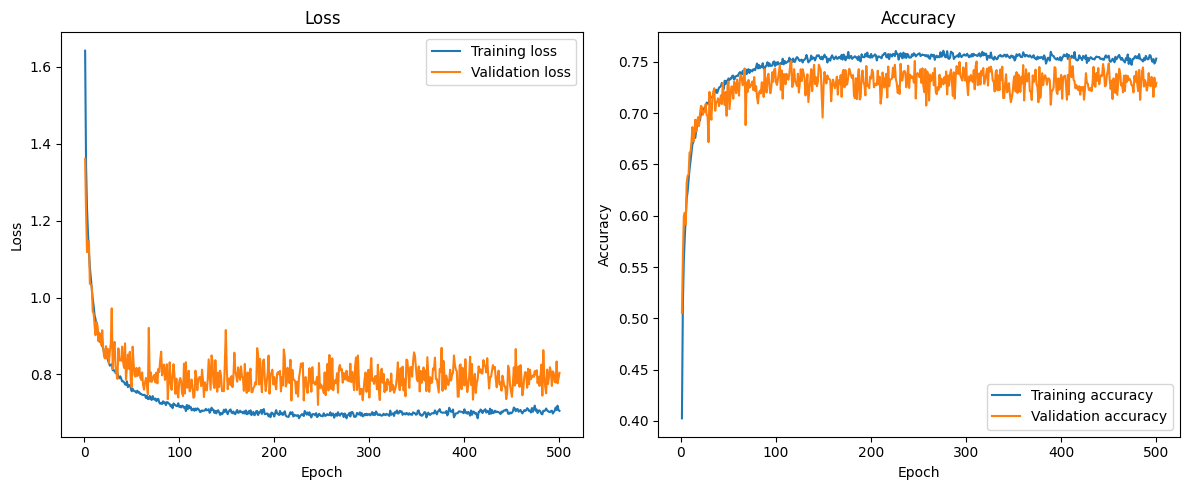

In [ ]:
import matplotlib.pyplot as plt


# 把資料從 history 取出
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')
accuracy = history_dict.get('accuracy') or history_dict.get('acc')
val_accuracy = history_dict.get('val_accuracy') or history_dict.get('val_acc')

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
if accuracy:
    plt.plot(epochs, accuracy, label='Training accuracy')
if val_accuracy:
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()